In [ ]:
# Install necessary packages
!pip install git+https://github.com/openai/CLIP.git
!pip install pillow
!pip install open-clip-torch

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, UnidentifiedImageError
import requests
from io import BytesIO
from os.path import expanduser
from urllib.request import urlretrieve

import clip
import open_clip

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP (ViT-B/32) from OpenAI
model_clip_b32, preprocess_clip_b32 = clip.load("ViT-B/32", device=device)

# Load CLIP (ViT-L/14) and LAION aesthetic predictor
def get_aesthetic_model(clip_model="vit_l_14"):
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = f"{cache_folder}/sa_0_4_{clip_model}_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = f"https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_{clip_model}_linear.pth?raw=true"
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError("Unsupported clip_model")
    state_dict = torch.load(path_to_model)
    m.load_state_dict(state_dict)
    m.eval()
    return m.to(device)

aesthetic_model_laion = get_aesthetic_model("vit_l_14")
clip_laion, _, preprocess_laion = open_clip.create_model_and_transforms("ViT-L-14", pretrained="openai")
clip_laion = clip_laion.to(device).eval()

# Load image from URL
def load_image_from_url(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert('RGB')
    except Exception as e:
        print("Failed to load image:", e)
        return None

# Random transformation
def random_transform(image):
    angle = np.random.uniform(-30, 30)
    image = image.rotate(angle)
    width, height = image.size
    crop_scale = np.random.uniform(0.8, 1.0)
    new_w, new_h = int(width * crop_scale), int(height * crop_scale)
    left = np.random.randint(0, width - new_w + 1)
    top = np.random.randint(0, height - new_h + 1)
    image = image.crop((left, top, left + new_w, top + new_h))
    image = image.resize((width, height), Image.LANCZOS)
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.7, 1.3))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.7, 1.3))
    return image

# Double exposure

def double_exposure(portrait, landscape, alpha):
    return Image.blend(portrait, landscape, alpha)

# Evaluate with OpenAI CLIP B32
def evaluate_openai_clip(image):
    image_input = preprocess_clip_b32(image).unsqueeze(0).to(device)
    text = clip.tokenize(["a beautiful photo"]).to(device)
    with torch.no_grad():
        image_features = model_clip_b32.encode_image(image_input)
        text_features = model_clip_b32.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        score = (image_features @ text_features.T).item() * 10
    return score

# Evaluate with OpenAI CLIP + specific prompt
def evaluate_openai_clip_custom(image):
    image_input = preprocess_clip_b32(image).unsqueeze(0).to(device)
    text = clip.tokenize(["a beautiful photo of double exposure"]).to(device)
    with torch.no_grad():
        image_features = model_clip_b32.encode_image(image_input)
        text_features = model_clip_b32.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        score = (image_features @ text_features.T).item() * 10
    return score

# Evaluate with LAION aesthetic predictor
def evaluate_laion(image):
    with torch.no_grad():
        image_input = preprocess_laion(image).unsqueeze(0).to(device)
        image_features = clip_laion.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        score = aesthetic_model_laion(image_features).item()
    return score

# Run search

def random_search_double_exposure_collect(portrait, landscape, trials=100):
    results = []
    for i in range(trials):
        p_trans = random_transform(portrait)
        l_trans = random_transform(landscape)
        alpha = np.random.uniform(0.3, 0.7)
        result_img = double_exposure(p_trans, l_trans, alpha)
        scores = {
            "openai_clip": evaluate_openai_clip(result_img),
            "openai_clip_custom": evaluate_openai_clip_custom(result_img),
            "laion": evaluate_laion(result_img),
        }
        results.append((scores, result_img, {"alpha": alpha}))
        print(f"Trial {i+1}/{trials} - Scores: {scores}")
    return results

# Main block
portrait_url = "https://images.unsplash.com/photo-1544005313-94ddf0286df2?fm=jpg&q=60&w=3000"
landscape_url = "https://images.pexels.com/photos/1619317/pexels-photo-1619317.jpeg?fm=jpg"

portrait_img = load_image_from_url(portrait_url)
landscape_img = load_image_from_url(landscape_url)

if portrait_img and landscape_img:
    size = (512, 512)
    portrait_img = portrait_img.resize(size)
    landscape_img = landscape_img.resize(size)

    results = random_search_double_exposure_collect(portrait_img, landscape_img, trials=100)
    for metric in ["openai_clip", "openai_clip_custom", "laion"]:
        sorted_results = sorted(results, key=lambda x: x[0][metric], reverse=True)
        best = sorted_results[:5]
        worst = sorted_results[-5:]

        # Show best
        plt.figure(figsize=(20, 4))
        for i, (scores, img, params) in enumerate(best):
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"{metric} Score: {scores[metric]:.2f}\nAlpha: {params['alpha']:.2f}")
            plt.axis('off')
        plt.suptitle(f"Best 5 - {metric}")
        plt.show()

        # Show worst
        plt.figure(figsize=(20, 4))
        for i, (scores, img, params) in enumerate(worst):
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"{metric} Score: {scores[metric]:.2f}\nAlpha: {params['alpha']:.2f}")
            plt.axis('off')
        plt.suptitle(f"Worst 5 - {metric}")
        plt.show()

Trial 1/100 - Scores: {'openai_clip': 2.138369530439377, 'openai_clip_custom': 2.6292836666107178, 'laion': 5.13114595413208}
Trial 2/100 - Scores: {'openai_clip': 2.2205671668052673, 'openai_clip_custom': 2.4570083618164062, 'laion': 3.8941123485565186}
Trial 3/100 - Scores: {'openai_clip': 2.2902169823646545, 'openai_clip_custom': 2.5451838970184326, 'laion': 3.8962461948394775}
Trial 4/100 - Scores: {'openai_clip': 2.2346635162830353, 'openai_clip_custom': 2.6316994428634644, 'laion': 3.6939334869384766}
Trial 5/100 - Scores: {'openai_clip': 2.1621784567832947, 'openai_clip_custom': 2.4060310423374176, 'laion': 3.3156075477600098}
Trial 6/100 - Scores: {'openai_clip': 2.1690014004707336, 'openai_clip_custom': 2.543659210205078, 'laion': 3.799384355545044}
Trial 7/100 - Scores: {'openai_clip': 2.085290402173996, 'openai_clip_custom': 2.570909857749939, 'laion': 3.668370485305786}
Trial 8/100 - Scores: {'openai_clip': 1.9049204885959625, 'openai_clip_custom': 2.3462796211242676, 'laio

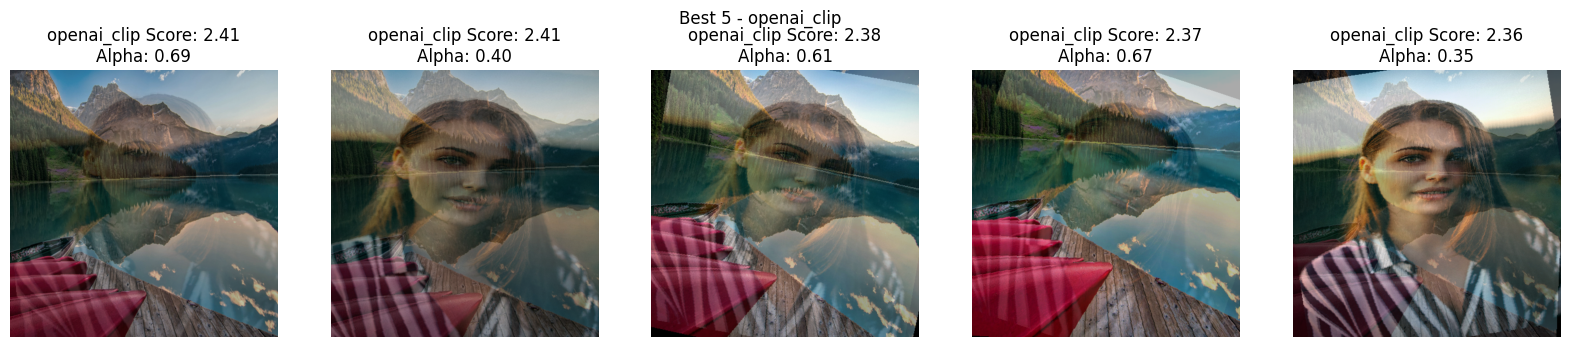

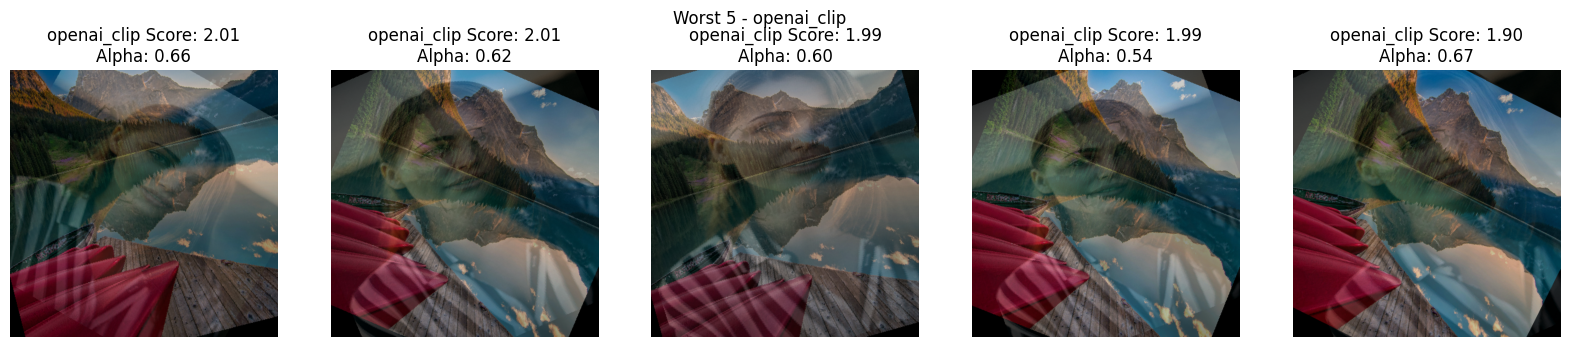

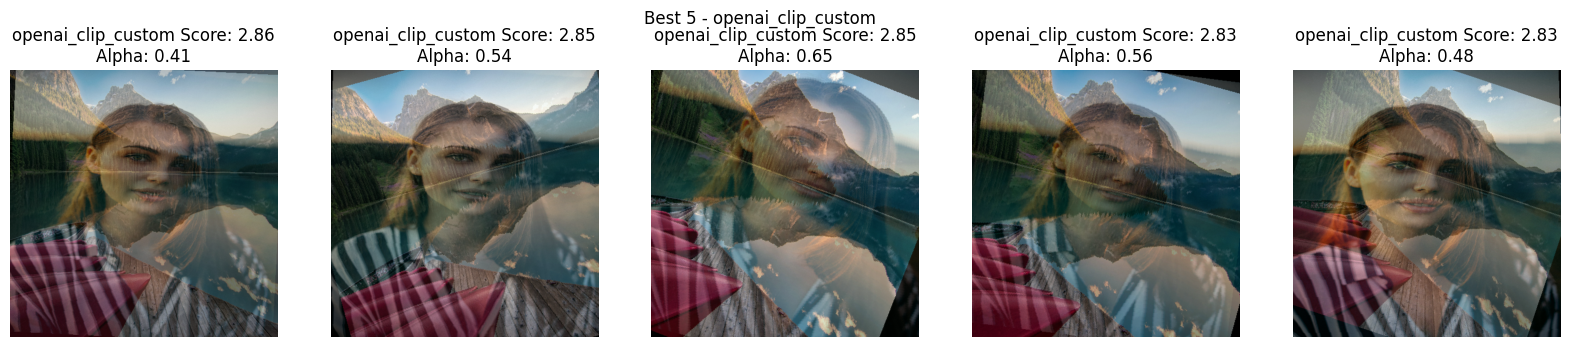

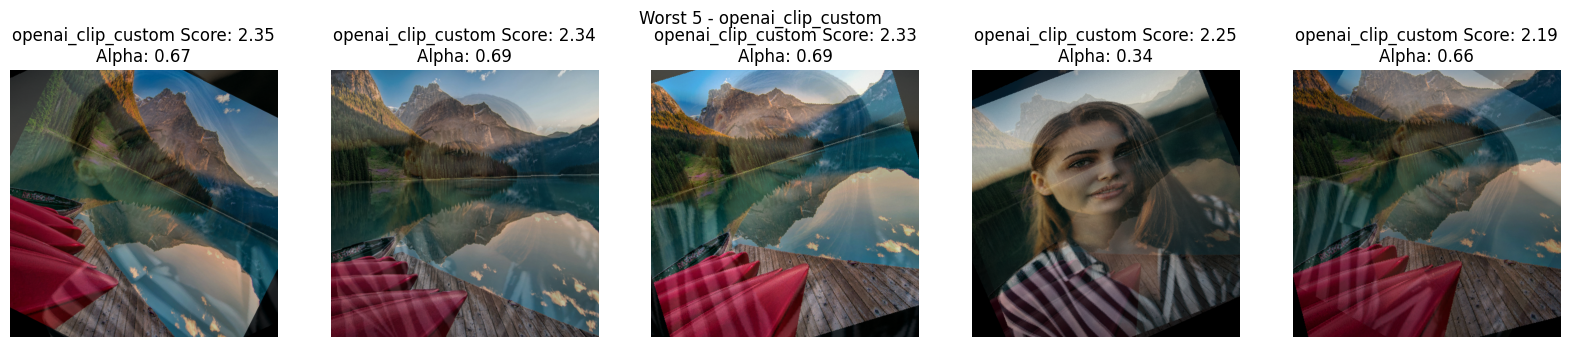

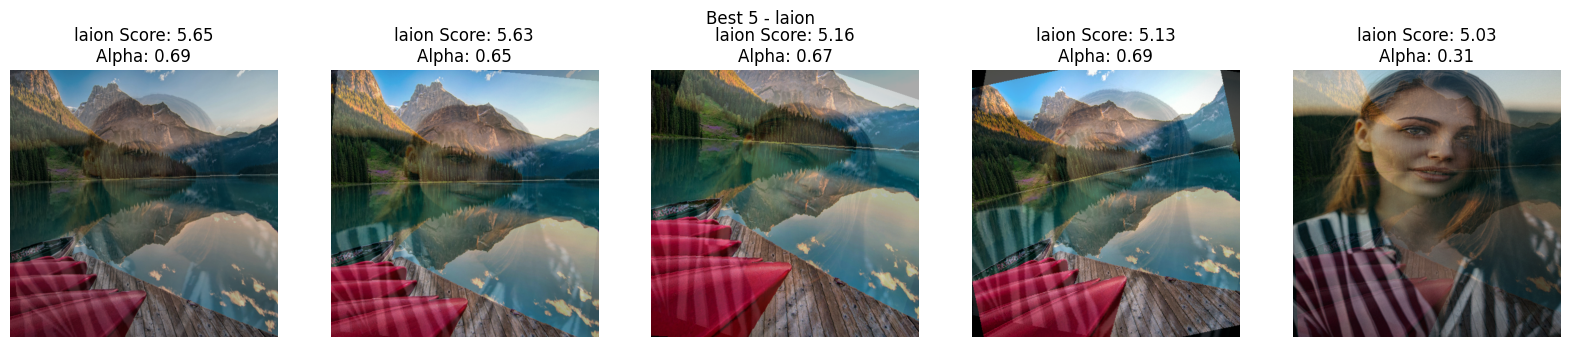

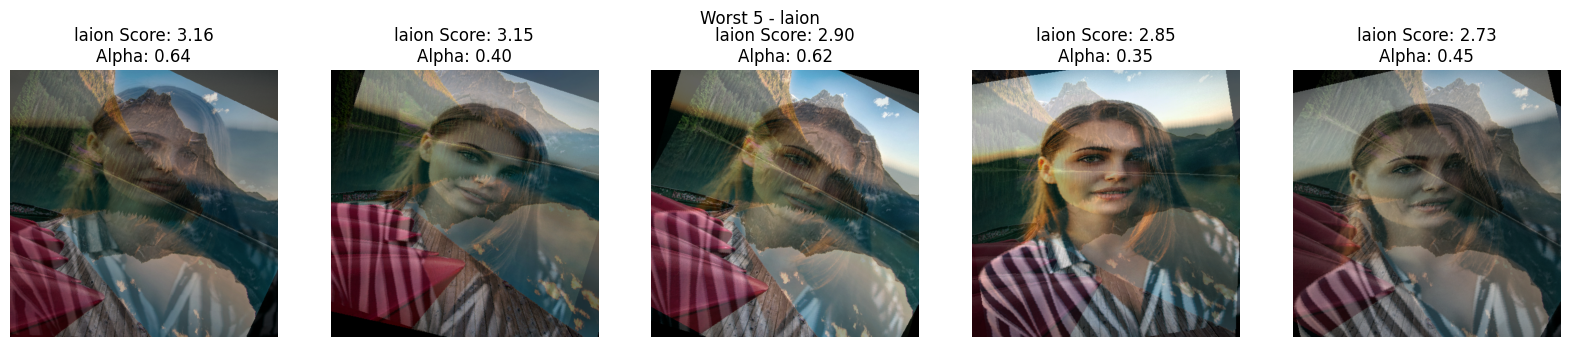

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, UnidentifiedImageError
import requests
from io import BytesIO
from os.path import expanduser
from urllib.request import urlretrieve

import clip
import open_clip

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP (ViT-B/32) from OpenAI
model_clip_b32, preprocess_clip_b32 = clip.load("ViT-B/32", device=device)

# Load CLIP (ViT-L/14) and LAION aesthetic predictor
def get_aesthetic_model(clip_model="vit_l_14"):
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = f"{cache_folder}/sa_0_4_{clip_model}_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = f"https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_{clip_model}_linear.pth?raw=true"
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError("Unsupported clip_model")
    state_dict = torch.load(path_to_model)
    m.load_state_dict(state_dict)
    m.eval()
    return m.to(device)

aesthetic_model_laion = get_aesthetic_model("vit_l_14")
clip_laion, _, preprocess_laion = open_clip.create_model_and_transforms("ViT-L-14", pretrained="openai")
clip_laion = clip_laion.to(device).eval()

# Load image from URL
def load_image_from_url(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert('RGB')
    except Exception as e:
        print("Failed to load image:", e)
        return None

# Random transformation
def random_transform(image):
    angle = np.random.uniform(-30, 30)
    image = image.rotate(angle)
    width, height = image.size
    crop_scale = np.random.uniform(0.8, 1.0)
    new_w, new_h = int(width * crop_scale), int(height * crop_scale)
    left = np.random.randint(0, width - new_w + 1)
    top = np.random.randint(0, height - new_h + 1)
    image = image.crop((left, top, left + new_w, top + new_h))
    image = image.resize((width, height), Image.LANCZOS)
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.7, 1.3))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.7, 1.3))
    return image

# Double exposure

def double_exposure(portrait, landscape, alpha):
    return Image.blend(portrait, landscape, alpha)

# Evaluate with OpenAI CLIP with prompt
def evaluate_openai_clip_with_prompt(image, prompt):
    image_input = preprocess_clip_b32(image).unsqueeze(0).to(device)
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        image_features = model_clip_b32.encode_image(image_input)
        text_features = model_clip_b32.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        score = (image_features @ text_features.T).item() * 10
    return score

# Evaluate with LAION aesthetic predictor
def evaluate_laion(image):
    with torch.no_grad():
        image_input = preprocess_laion(image).unsqueeze(0).to(device)
        image_features = clip_laion.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        score = aesthetic_model_laion(image_features).item()
    return score

# Run search

def random_search_double_exposure_collect(portrait, landscape, trials=100):
    results = []
    for i in range(trials):
        p_trans = random_transform(portrait)
        l_trans = random_transform(landscape)
        alpha = np.random.uniform(0.3, 0.7)
        result_img = double_exposure(p_trans, l_trans, alpha)
        scores = {
            "openai_clip": evaluate_openai_clip_with_prompt(result_img, "a beautiful photo"),
            "openai_clip_custom": evaluate_openai_clip_with_prompt(result_img, "a beautiful photo of double exposure"),
            "laion": evaluate_laion(result_img),
        }
        results.append((scores, result_img, {"alpha": alpha}))
        print(f"Trial {i+1}/{trials} - Scores: {scores}")
    return results

# Main block
portrait_url = "https://images.unsplash.com/photo-1544005313-94ddf0286df2?fm=jpg&q=60&w=3000"
landscape_url = "https://images.pexels.com/photos/1619317/pexels-photo-1619317.jpeg?fm=jpg"

portrait_img = load_image_from_url(portrait_url)
landscape_img = load_image_from_url(landscape_url)

if portrait_img and landscape_img:
    size = (512, 512)
    portrait_img = portrait_img.resize(size)
    landscape_img = landscape_img.resize(size)

    results = random_search_double_exposure_collect(portrait_img, landscape_img, trials=100)
    for metric in ["openai_clip", "openai_clip_custom", "laion"]:
        sorted_results = sorted(results, key=lambda x: x[0][metric], reverse=True)
        best = sorted_results[:5]
        worst = sorted_results[-5:]

        # Show best
        plt.figure(figsize=(20, 4))
        for i, (scores, img, params) in enumerate(best):
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"{metric} Score: {scores[metric]:.2f}\nAlpha: {params['alpha']:.2f}")
            plt.axis('off')
        plt.suptitle(f"Best 5 - {metric}")
        plt.show()

        # Show worst
        plt.figure(figsize=(20, 4))
        for i, (scores, img, params) in enumerate(worst):
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"{metric} Score: {scores[metric]:.2f}\nAlpha: {params['alpha']:.2f}")
            plt.axis('off')
        plt.suptitle(f"Worst 5 - {metric}")
        plt.show()
